In [69]:
import os, subprocess
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker, cm
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import leastsq
import tqdm

import pycbc.waveform
import cosmolopy.distance as cd

from gwaxion import physics

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cosmo = {'omega_M_0':0.308, 'omega_lambda_0':0.692, 'omega_k_0':0.0, 'h':0.678}

# Horizon

To find the horizon we want to set $\rho = 1$, where
\begin{equation*}
\rho \equiv \frac{h_\oplus}{h_{\rm th}(f_\oplus)} = \left( \frac{h_0}{h_{95}} d_0\, {\rm ASD}_{95} \right) \frac{1}{d_z\, {\rm ASD}[f_0\left(1+z\right)^{-1}]}\, ,
\end{equation*}
and $h_\oplus$ and $f_\oplus$ are the GW amplitude and frequency measured at Earth, namely
\begin{align}
h_\oplus &= h_0 \frac{d_0}{d_z}\, ,\\
f_\oplus &= f_0 \left(1+z\right)^{-1}\, ,
\end{align}
with $f_0$ the source-frame GW frequency and $h_0$ the strain at luminosity distance $d_0$.

The denominator in the second factor above can be interpolated for $f_0$ and $z$.

In [321]:
def h95_viterbi(asd_f, T=None):
    # From Lilli: 95% detection efficiency h0 is 4.7e-26 at 201.2 Hz and an ASD of 4E-24 Sqrt[Hz], for T=80 days
    h95ref = 4.7E-26
    f95ref = 201.2
    asd95ref = 4E-24
    Tref = 80*physics.DAYSID_SI
    T = T if T is not None else Tref
    return h95ref * (asd_f/asd95ref) * (Tref/T)**0.25

def euclidean_horizon(h0, f=None, asd_interp=None, dref=5, T=None):
    """ Computes horizon (Mpc) assuming no redshift."""
    asd = asd_interp(f)
    h95 = h95_viterbi(asd, T=T)
    return h0 * dref / h95

def z_to_dl(z):
    return cd.luminosity_distance(z, **cosmo)

## find redshift for a given luminosity distance
def dl_to_z(dl, z0=1):
    return leastsq(lambda z: dl - cd.luminosity_distance(z, **cosmo), z0)[0]

# ## estimate the horizon for recursive evaluation in the main code
# def horizon_dist_eval(h_ratio, d0, z0):
#     guess_dist = d0*h_ratio
#     guess_redshift, res = leastsq(findzfromDL, z0, args=guess_dist)
#     return guess_redshift[0], guess_dist



In [216]:
# define h and z factors

h95ref = 4.7E-26
asd95ref = 4E-24
log_d0 = np.log10(5)
log_h95ref = np.log10(h95ref)
log_asd95ref = np.log10(asd95ref)

def log_h_factor(h0):
    log_h0 = np.log10(h0)
    return log_h0 + log_d0 + log_asd95ref - log_h95ref

def log_z_factor(f0, z, asd_interp):
    dz = cd.luminosity_distance(z, **cosmo)
    fz = f0/(1. + z)
    return np.log10(dz * asd_interp(fz))

# horizon-finding functions
def compute_log_zH_brentq(h0, f0, asd_interp, log_z_min=-9, log_z_max=2):
    try:
        log_zH = brentq(lambda log_z: log_h_factor(h0) - log_z_factor(f0, 10**log_z, asd_interp), log_z_min, log_z_max)
    except ValueError:
        log_zH = np.nan
    return log_zH
            
def compute_log_zH_leastsq(h0, f0, asd_interp, log_z_guess=0):
    log_zH = leastsq(lambda log_z: log_h_factor(h0) - log_z_factor(f0, 10**log_z, asd_interp), log_z_guess)[0]
    return log_zH

In [169]:
# test horizon finders

%timeit log_zH_leastsq = compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)

%timeit log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)


100 loops, best of 3: 3.32 ms per loop
[5.86249719]
100 loops, best of 3: 2.28 ms per loop
[5.86249719]


In [177]:
# find approx redshift for dL = 1 pc
print dl_to_z(1E-6)
print "%.1e pc" % (z_to_dl(2.5E-10)*1E6)

[2.26156457e-10]
1.1e+00 pc


## Create data

In [147]:
from scipy.optimize import root, brentq, fsolve

h0_array = np.logspace(-27, -22, 50)
f0_array = np.logspace(np.log10(30), 4, 50)

# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
h0s, f0s, log_zHs = [], [], []
with tqdm.tqdm(range(len(h0_array)*len(f0_array))) as pbar:
    for h0 in h0_array:
        for f0 in f0_array:
            log_zHs.append(compute_log_zH_brentq(h0, f0, asd_des_interp))
            h0s.append(h0)
            f0s.append(f0)
            pbar.update()
            
h0s = np.array(h0s)
f0s = np.array(f0s)
log_zHs = np.array(log_zHs)

100%|██████████| 2500/2500 [00:04<00:00, 583.08it/s]


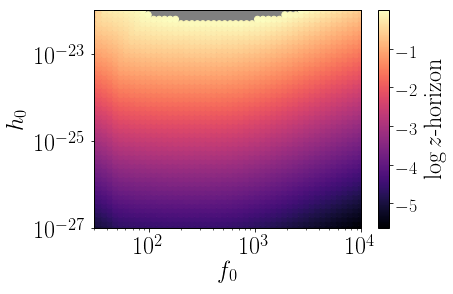

In [149]:
# diagnose interpolant data

fig, ax = plt.subplots(1)
cm = ax.scatter(f0s, h0s, c=log_zHs, cmap='magma')

# add colorbar
cb = plt.colorbar(cm, label=r'$\log z$-horizon')
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$f_0$')
plt.ylabel(r'$h_0$')
ax.patch.set_facecolor("grey")

plt.xscale('log')
plt.yscale('log')

plt.xlim(30, 1E4)
plt.ylim(1E-27, 1E-22)

plt.show()
plt.close()

## Source frame

Load source-frame quantities from disk, or create if not found

In [217]:
dfpath = 'new_peak.hdf5'
if os.path.exists(dfpath):
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
else:
    n_mass = 500
    n_chi = 200
    n_alpha = 1000

    distance = 5E6 * physics.PC_SI

    mbhs_array = np.logspace(-1, 4, n_mass)
    chis_array = np.linspace(1E-4, 1, n_chi)

    alphas = np.linspace(0, 0.5, n_alpha)
    rows = []
    with tqdm.tqdm(range(len(mbhs_array)*len(chis_array))) as pbar:
        for mbh in mbhs_array:
            for chi in chis_array:
                h0s, fgws = physics.h0_scalar_brito(mbh, alphas, chi_i=chi, d=distance)
                hmax = np.nanmax(h0s)
                fmax = fgws[h0s==hmax][0]
                amax = alphas[h0s==hmax][0]
                rows.append({'mbh': mbh, 'chi': chi, 'h0': hmax, 'fgw': fmax, 'alpha': amax})
                pbar.update()
    df_max = pd.DataFrame(rows)
    df_max.to_hdf(dfpath, 'table', mode='w')

100%|██████████| 100000/100000 [00:16<00:00, 6029.36it/s]


In [227]:
# condition data
df_cond = df_max[(df_max['fgw']>=0.1) & (df_max['fgw']<=1E6) & (df_max['h0']>1E-40)].copy()

# aLIGO design

## PSD

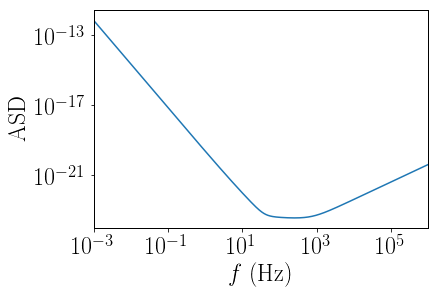

In [276]:
from lalsimulation import SimNoisePSDaLIGOZeroDetHighPower

flow = 0.001
fhig = 1E6
freqs = np.linspace(flow, fhig, int(5E6))

psd_des = np.array([SimNoisePSDaLIGOZeroDetHighPower(f) for f in freqs])
asd_des = psd_des**0.5

psd_des_interp = interp1d(freqs, psd_des)
asd_des_interp = interp1d(freqs, asd_des, bounds_error=False, fill_value=np.inf)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd_des)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(flow, fhig)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

## Range

In [277]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0

log_zHs_des = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_des.append(compute_log_zH_brentq(h0, f0, asd_des_interp))
        pbar.update()        
log_zHs_des = np.array(log_zHs_des)

100%|██████████| 98092/98092 [04:23<00:00, 372.57it/s]


In [278]:
df_cond['log_zH_des'] = log_zHs_des
df_cond.to_hdf('new_peak_horizon_des.hdf5', 'table', mode='w')

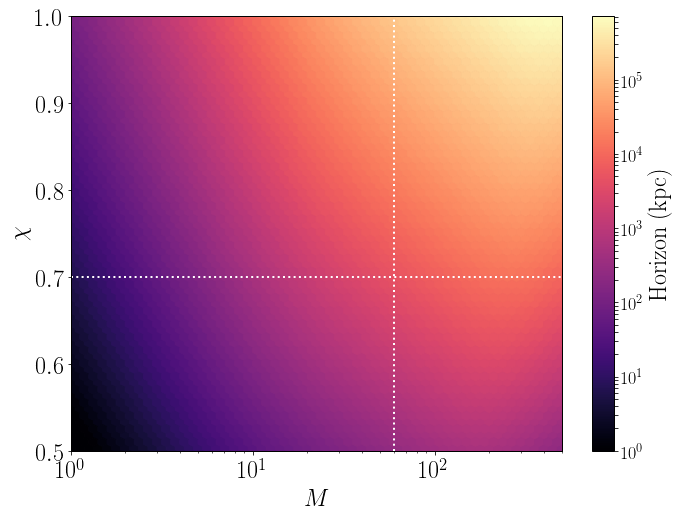

In [339]:
# plot

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_des'])*1E3

fig, ax = plt.subplots(1, figsize=(11,8))
norm = matplotlib.colors.LogNorm(vmin=1, vmax=C.max())
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (kpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("gray")

plt.xscale('log')

ax.set_xlim(1, 5E2)
plt.ylim(0.5, 1)

fig.savefig('cmap_chi_mbh_range_design.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [280]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_des'].max())
print "GW150914 horizon: %.1f Mpc" % (z_to_dl(10**compute_log_zH_brentq(4E-26, 200, asd_des_interp)))

Maximum redshift: 1.48e-01
GW150914 horizon: 4.7 Mpc


# Voyager

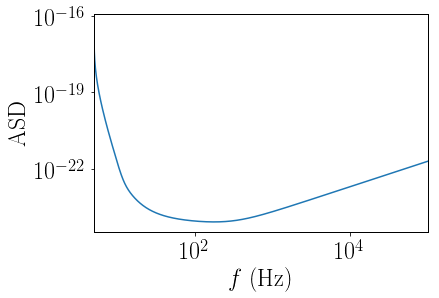

Voyager band:
5.0 100000.0


In [304]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/voyager.txt')
freqs, asd_voy_array = vals[:,0], vals[:,1]

# create interpolant
asd_voy_interp = interp1d(freqs, asd_voy_array, fill_value='extrapolate')

fmin, fmax = freqs.min(), 1E5 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(freqs, asd_voy_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

print "Voyager band:"
print fmin, fmax

In [290]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_voy = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_voy.append(compute_log_zH_brentq(h0, f0, asd_voy_interp))
        pbar.update()        
log_zHs_voy = np.array(log_zHs_voy)

100%|██████████| 98092/98092 [07:52<00:00, 207.42it/s]


In [292]:
df_cond['log_zH_voy'] = log_zHs_voy
df_cond.to_hdf('new_peak_horizon_voy.hdf5', 'table', mode='w')

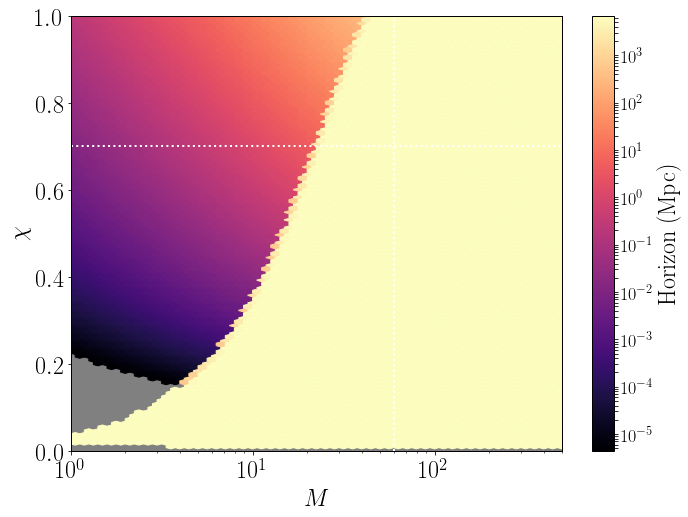

In [293]:
# plot

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_voy'])

fig, ax = plt.subplots(1, figsize=(11,8))
norm = matplotlib.colors.LogNorm(vmin=C.min(), vmax=C.max())
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("gray")

plt.xscale('log')

ax.set_xlim(1, 5E2)
plt.ylim(0, 1)

fig.savefig('cmap_chi_mbh_range_voyager.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

# Cosmic Explorer

5.0 100000.0


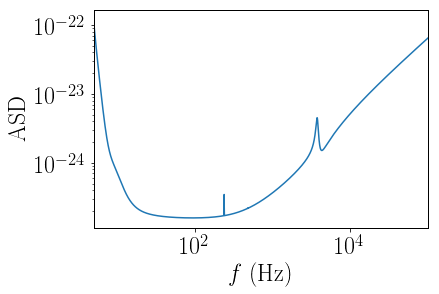

CE band:
5.0 100000.0


In [309]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/ce.txt')
freqs, asd_voy_array = vals[:,0], vals[:,1]

print fmin, fmax
# create interpolant
asd_ce_interp = interp1d(freqs, asd_voy_array, fill_value='extrapolate')

fmin, fmax = freqs.min(), 1E5 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(freqs, asd_ce_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

print "CE band:"
print fmin, fmax

In [310]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_ce = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_ce.append(compute_log_zH_brentq(h0, f0, asd_ce_interp))
        pbar.update()        
log_zHs_ce = np.array(log_zHs_ce)

100%|██████████| 98092/98092 [05:04<00:00, 321.69it/s]


In [312]:
df_cond['log_zH_ce'] = log_zHs_ce
df_cond.to_hdf('new_peak_horizon_ce.hdf5', 'table', mode='w')

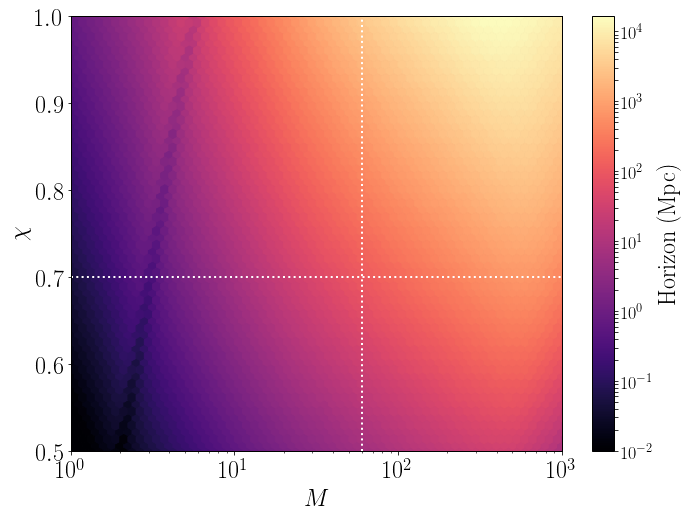

In [338]:
# plot

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_ce'])

fig, ax = plt.subplots(1, figsize=(11,8))
norm = matplotlib.colors.LogNorm(vmin=1E-2, vmax=C.max())
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("gray")

plt.xscale('log')

ax.set_xlim(1, 1E3)
plt.ylim(0.5, 1)

fig.savefig('cmap_chi_mbh_range_ce.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [315]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_ce'].max())
print "GW150914 horizon: %.1f Mpc" % (z_to_dl(10**compute_log_zH_brentq(4E-26, 200, asd_ce_interp)))

Maximum redshift: 2.07e+00
GW150914 horizon: 102.7 Mpc


## Peak emission

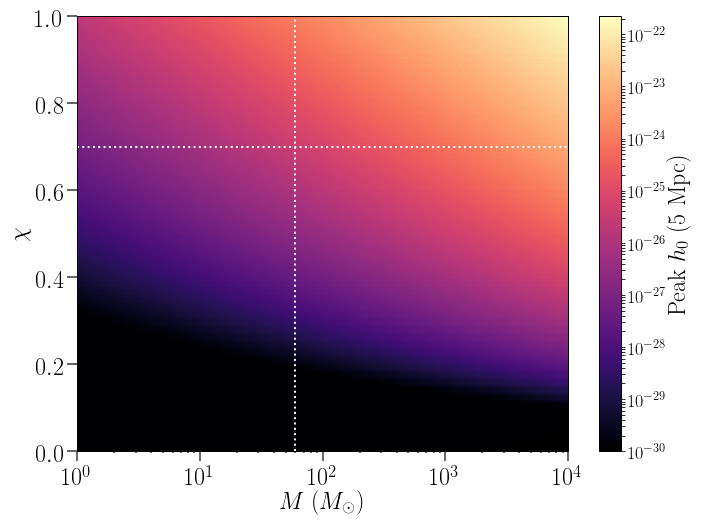

In [337]:
# colormap for peak h0 vs chi vs M

h0s = df_cond['h0']
hmax_ma = np.ma.masked_array(h0s, mask=(h0s<=0))

hmin, hmax = 1E-30, hmax_ma.max()
norm = matplotlib.colors.LogNorm(vmin=hmin, vmax=hmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(df_cond['mbh'], df_cond['chi'], C=hmax_ma, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $h_0$ (5 Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("black")

#plt.xlim(1, 1E4)
ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_h0.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

# PSD and h95's

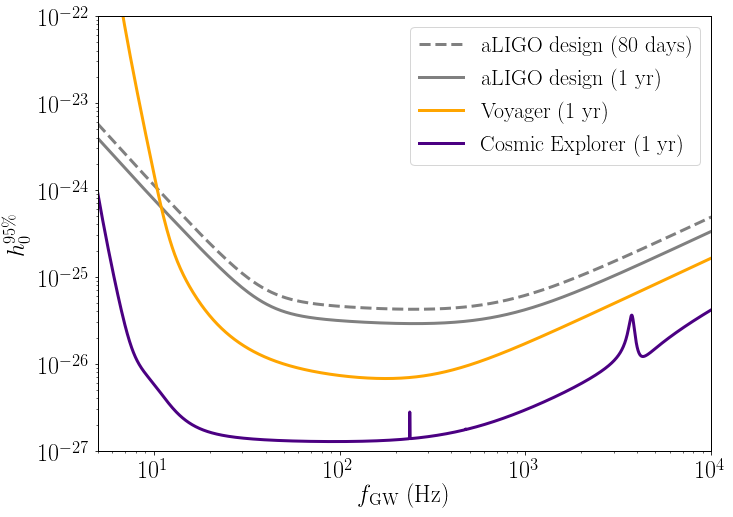

In [336]:
# use Voyager frequency array for the x-axis

year = 365*physics.DAYSID_SI

freqs = np.logspace(np.log10(5), 4, int(1E5))

fig, ax = plt.subplots(1, figsize=(11,8))
ax.plot(freqs, h95_viterbi(asd_des_interp(freqs)), label="aLIGO design (80 days)", lw=3, c='gray', ls='--')
ax.plot(freqs, h95_viterbi(asd_des_interp(freqs), T=year), label="aLIGO design (1 yr)", lw=3, c='gray')
ax.plot(freqs, h95_viterbi(asd_voy_interp(freqs), T=year), label="Voyager (1 yr)", lw=3, c='orange')
ax.plot(freqs, h95_viterbi(asd_ce_interp(freqs), T=year), label="Cosmic Explorer (1 yr)", lw=3, c='indigo')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(freqs.min(), freqs.max())
ax.set_ylim(1E-27, 1E-22)

ax.set_xlabel(r'$f_{\rm GW}$ (Hz)')
ax.set_ylabel(r'$h^{95\%}_0$')

ax.legend(loc='best', fontsize=22)

fig.savefig('plot_h095_fgw.png', bbox_inches='tight')

plt.show(fig)
plt.close()